# Using SageMaker Python SDK to train a linear learner algorithm

### NOTE: Start this notebook with mxnet kernel. We need that later in this notebook
First we need to upload the experience and salary csv file into the file system of this notebook instance and create a data frame:

In [1]:
import pandas as pd
filename = "experience_and_salary.csv"
df_all_data = pd.read_csv(filename)

In [2]:
df_all_data 

,last_name,management_experience_months,monthly_salary
0,Taylor,65,1630
1,Wang,61,1330
2,Brown,38,1290
3,Harris,71,1480
4,Jones,94,1590
5,Garcia,93,1750
6,Williams,15,1020
7,Lee,56,1290
8,White,59,1430
9,Tan,7,960


As you see, this data set is not big but if it was a big data set, you would show first (head()) or last (tail()) lines. You would also clean the data like removing the unwanted columns or imputing missing values. 

The next step is to show the linear relationship between feature(s) and label in this data set. We show that by drawing the scatter plot between x and y:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


(0.0, 2400.0)

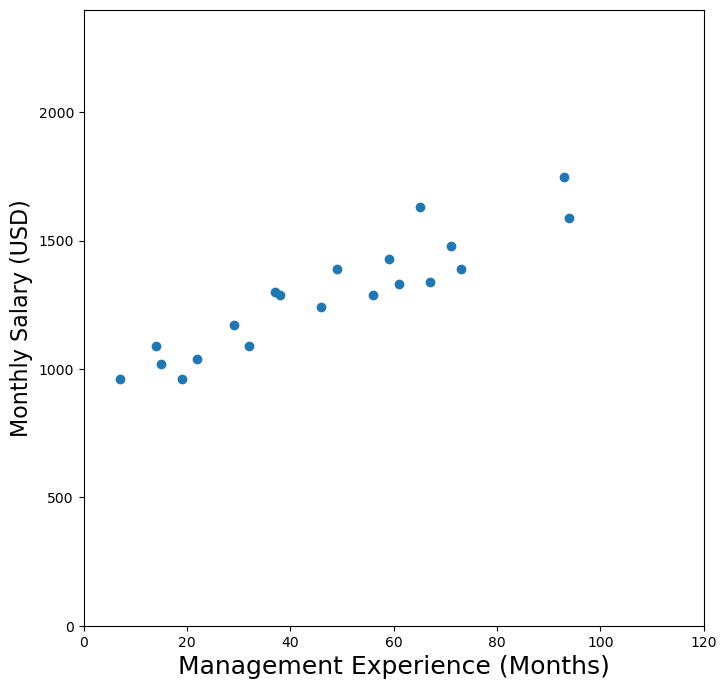

In [4]:
plt.rcParams["figure.figsize"] = (8,8) 
plt.scatter(df_all_data.management_experience_months, df_all_data.monthly_salary)
plt.xlabel('Management Experience (Months)', fontsize=18) 
plt.ylabel('Monthly Salary (USD)', fontsize=16) 
plt.xlim(0, 120)
plt.ylim(0, 2400)

As you see in the above picture, the relationship is close to linear and they are positive correlation. So this suggest using a linear learner algorith would be a good choise to model the relationship between these two variable.

Next we create the training and testing data set:

In [5]:
from sklearn.model_selection import train_test_split

X = df_all_data['management_experience_months'].values 
y = df_all_data['monthly_salary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Let's check the distribution of data between these two data sets:

In [6]:
X_train

array([15, 49, 94, 38, 93, 46,  7, 56, 19, 67, 71, 65, 73, 29])

In [7]:
X_test

array([32, 61, 37, 59, 14, 22])

Let's see x and y for the training data set in one table:

In [8]:
import pandas as pd
df_training_data = pd.DataFrame({ 'monthly_salary': y_train, 'management_experience_months': X_train})
df_training_data

,monthly_salary,management_experience_months
0,1020,15
1,1390,49
2,1590,94
3,1290,38
4,1750,93
5,1240,46
6,960,7
7,1290,56
8,960,19
9,1340,67


Let's save this data set into file system:

In [9]:
df_training_data.to_csv('day-06-training_data.csv', header=False, index=False)

We need to load this file to S3 to be able to pass its address to the SageMaker API training API. So first we set the S3 bucket name variable (you have to change that name to your bucket name). You do not need to have the prefix folder in place, just bucket name must exists. 

In [10]:
s3_bucket = 'day06-humber'
prefix = 'linearlearner'

Then we upload the file to the bucket:

In [11]:
!aws s3 cp day-06-training_data.csv s3://{s3_bucket}/{prefix}/input/day-06-training_data.csv

upload: ./day-06-training_data.csv to s3://day06-humber/linearlearner/input/day-06-training_data.csv


Before you go ahead to the next step, check  your S3 bucket and make sure the training data is there.

Now we set up everything we need for starting a SageMaker training instance:

In [12]:
import sagemaker 
import boto3
from sagemaker import get_execution_role 

role = get_execution_role()
session = sagemaker.Session()
region_name = boto3.Session().region_name

Now you set where the training data set is located on S3 and where the model artifact should be stored:

In [13]:
training_s3_input_location = f"s3://{s3_bucket}/{prefix}/input/day-06-training_data.csv" 
training_s3_output_location = f"s3://{s3_bucket}/{prefix}/output/"

Prepare the S3 input parameter with content type "text/csv". This step is needed for the algorithms that support more than one type of input format and you want to set the data type format to something different than the default value. For example, we want to use lieaner learner algorithm and it supports recordIO-wrapper protobuf format. That is more efficient than csv file and it is useful when you have a large data set. 

In [14]:
from sagemaker.inputs import TrainingInput

train = TrainingInput(training_s3_input_location, content_type="text/csv")

Prepare the image URL for the linear learner algorithm. SageMaker SDK has a retrive() method to get its address:

In [15]:
from sagemaker.image_uris import retrieve 

container = retrieve("linear-learner", region_name, "1")
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

So the above address is the address of Linear Learner image in ECR.

The next step is creating an estimator object. The estimator object maintains the infrastructure requirments of the future training job. You refer to this estimator name in the future API calls:

In [16]:
estimator = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m5.xlarge',
    output_path=training_s3_output_location,
    sagemaker_session=session)

NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.


Please consider that the SageMaker launches new training instance outside of this current jupyter instance. That is a new server and it will be terminated automatically when the training is completes. The number of training instances depends on the instance_count value in the estimator object parameters. Later when we call **.fit()**, the SageMaker creates servers equal to the number of instances.

Please note that in SageMaker, sometimes we can use **algorithm-specific estimator** like LinearLearner class which abstracts the container image. Here we use a **general** Estimator object than specific algorithm estimator. 

We use the same estimator name for other settings of this training job such as setting its <u>hyperparameters</u>. For example, the linear learner algorithm in the SageMaker can be used for both classification and regression problems and we set which mode of operation we want in this scenario by setting the predictor type. If it was a classification problem we would set that as "binary_classifier". 

In [17]:
estimator.set_hyperparameters(predictor_type='regressor', mini_batch_size=4)

Now that we have set the estimator configuration and its hyperparameters, we start training by calling **.fit()** function. When you start training, go to console and see what's happening in SageMaker training job:

In [18]:
estimator.fit({'train': train})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-10-08-12-42-53-472


2023-10-08 12:42:53 Starting - Starting the training job...
2023-10-08 12:43:08 Starting - Preparing the instances for training......
2023-10-08 12:44:09 Downloading - Downloading input data...
2023-10-08 12:44:34 Training - Downloading the training image......
2023-10-08 12:45:45 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[10/08/2023 12:45:40 INFO 140032014460736] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0'

As you see, I did not pass any validation data set here. Here we have a very small data set and setting aside a validation data set is not reasonable but usually in real world scenarios we do that. 

In the above output, pay attention to **"Downloading input data" and "Training image download"**. These are prerequisites before starting any training job. Then at the end, we have **uploading generated training model** and completing the job and total time that this training job takes. 

Now, if you go the output folder you set earlier you should be able to see the model artifact there. 

All information about this estimator object is extract-able by running the following command:

In [19]:
estimator.__dict__

{'image_uri': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
 '_hyperparameters': {'predictor_type': 'regressor', 'mini_batch_size': 4},
 'instance_count': 1,
 'instance_type': 'ml.m5.xlarge',
 'keep_alive_period_in_seconds': None,
 'instance_groups': None,
 'volume_size': 30,
 'max_run': 86400,
 'input_mode': 'File',
 'metric_definitions': None,
 'model_uri': None,
 'model_channel_name': 'model',
 'code_uri': None,
 'code_channel_name': 'code',
 'source_dir': None,
 'git_config': None,
 'container_log_level': 20,
 'code_location': None,
 'entry_point': None,
 'dependencies': [],
 'uploaded_code': None,
 'tags': None,
 'sagemaker_session': <sagemaker.session.Session at 0x7f68f46679a0>,
 'base_job_name': 'linear-learner',
 '_current_job_name': 'linear-learner-2023-10-08-12-42-53-472',
 'output_path': 's3://day06-humber/linearlearner/output/',
 'latest_training_job': <sagemaker.estimator._TrainingJob at 0x7f69058e16f0>,
 'jobs': [<sagemaker.estimator._TrainingJob at 0x7

At this point the training through Python SDK is done but I want you to know what is inside that model and we actully use that to do some prediction for us. This is just to give you a deeper understanding about the internals of the model artifact.

Lets first grab that model artifact and save that in this notebook instance. Let's copy the value of the estimator model:

In [20]:
model_data = estimator.model_data
model_data

's3://day06-humber/linearlearner/output/linear-learner-2023-10-08-12-42-53-472/output/model.tar.gz'

We use the above path and copy that model artifact inside this notebook instance (**change** the folder name after /output/ accordingly)

In [31]:
!aws s3 cp s3://day06-humber/linearlearner/output/linear-learner-2023-10-08-12-42-53-472/output/model.tar.gz .

download: s3://day06-humber/linearlearner/output/linear-learner-2023-10-08-12-42-53-472/output/model.tar.gz to ./model.tar.gz


Now we set the estimator image URI. We will use this URL later.

In [32]:
model_uri = estimator.image_uri
model_uri

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

Now that we have the model artifact downloaded, let's unzip it:

In [33]:
!tar -xzvf model.tar.gz

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
model_algo-1


When you unzip that you get these files:

In [34]:
!unzip model_algo-1 

Archive:  model_algo-1
 extracting: mx-mod-symbol.json      
 extracting: mx-mod-0000.params      
 extracting: manifest.json           
 extracting: additional-params.json  


<b>mx-mod-symbol.json:</b> This file contains the symbolic representation of the model's neural network architecture. In the context of neural networks, the "symbolic" representation refers to the defined structure of the model (e.g., layers, operations) without the learned weights and biases.

<b>mx-mod-0000.params:</b> This file contains the learned weights and biases for the model. These are the values that are adjusted during the training process to make the model accurate for a specific dataset.

<b> manifest.json:</b>  This file contains metadata about the model artifact. It  include information about the framework version, creation timestamp, and other model-specific metadata. The SageMaker platform uses this to understand the model's structure and requirements.

<b> additional-params.json:</b> This file would contain any additional parameters or configuration settings that are important for the deployment or use of the model.

Now that the model files are extracted we can get the bias and weights of this linear regression model:

Behind the scene Amazon uses mxnet framework to create that linear learner. So we first start loading the required libraries:

In [35]:
!pip install mxnet
import mxnet

from mxnet import gluon
from json import load as json_load 
from json import dumps as json_dumps

Now let's load the model from the extracted contents. The model we create in the following cell will be used later for inferencing through mxnet (not through SageMaker). It gets data as input and returns symbolic json as output. Please do not worry about the warning you may get as part of executing the following code:

In [36]:
sym_json = json_load(open('mx-mod-symbol.json')) 
sym_json_string = json_dumps(sym_json)

model = gluon.nn.SymbolBlock( 
    outputs=mxnet.sym.load_json(sym_json_string), 
    inputs=mxnet.sym.var('data'))

model.load_parameters('mx-mod-0000.params', allow_missing=True)

[12:51:57] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.3.1. Attempting to upgrade...
[12:51:57] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/mxnet/gluon/block.py:1784: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


I am sure you will learn later about symbolic structures but for now just to show you how that looks like:

In [37]:
sym_json

{'nodes': [{'op': 'null', 'name': 'data', 'inputs': []},
  {'op': 'null',
   'name': 'fc0_weight',
   'attrs': {'__shape__': '(1, 1)'},
   'inputs': []},
  {'op': 'dot', 'name': 'dot47', 'inputs': [[0, 0, 0], [1, 0, 0]]},
  {'op': 'null',
   'name': 'fc0_bias',
   'attrs': {'__lr_mult__': '10.0', '__shape__': '(1, 1)'},
   'inputs': []},
  {'op': 'broadcast_add',
   'name': 'broadcast_plus47',
   'inputs': [[2, 0, 0], [3, 0, 0]]},
  {'op': 'null', 'name': 'out_label', 'inputs': []},
  {'op': 'LinearRegressionOutput',
   'name': 'linearregressionoutput47',
   'inputs': [[4, 0, 0], [5, 0, 0]]}],
 'arg_nodes': [0, 1, 3, 5],
 'node_row_ptr': [0, 1, 2, 3, 4, 5, 6, 7],
 'heads': [[6, 0, 0]],
 'attrs': {'mxnet_version': ['int', 10301]}}

In [38]:
sym_json_string

'{"nodes": [{"op": "null", "name": "data", "inputs": []}, {"op": "null", "name": "fc0_weight", "attrs": {"__shape__": "(1, 1)"}, "inputs": []}, {"op": "dot", "name": "dot47", "inputs": [[0, 0, 0], [1, 0, 0]]}, {"op": "null", "name": "fc0_bias", "attrs": {"__lr_mult__": "10.0", "__shape__": "(1, 1)"}, "inputs": []}, {"op": "broadcast_add", "name": "broadcast_plus47", "inputs": [[2, 0, 0], [3, 0, 0]]}, {"op": "null", "name": "out_label", "inputs": []}, {"op": "LinearRegressionOutput", "name": "linearregressionoutput47", "inputs": [[4, 0, 0], [5, 0, 0]]}], "arg_nodes": [0, 1, 3, 5], "node_row_ptr": [0, 1, 2, 3, 4, 5, 6, 7], "heads": [[6, 0, 0]], "attrs": {"mxnet_version": ["int", 10301]}}'

Now that we define what the model is, we initialize that. we create a local mxnet_predict function in the following cell. It gets the model we have created in the previous step and it returns the value of y:

In [39]:
model.initialize()

def mxnet_predict(x, model=model):
    return model(mxnet.nd.array([x]))[0].asscalar()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'fc0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/mxnet/gluon/parameter.py:896: UserWarning: Parameter 'fc0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)


Now, let's perform a prediction:

In [40]:
mxnet_predict(42)

1226.6005

We can also get the weight and bias of this model:

In [41]:
def extract_weight_and_bias(model):
    params = model.collect_params()
    weight = params['fc0_weight'].data()[0].asscalar() 
    bias = params['fc0_bias'].data()[0].asscalar()
    
    return {
        "weight": weight, 
        "bias": bias
    } 

In [42]:
weight_and_bias = extract_weight_and_bias(model)
weight_and_bias

{'weight': 8.219234, 'bias': 881.3926}